In [1]:
import catboost
import pathlib
import shutil
import tempfile
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import lightgbm as ltb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import regularizers

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from  IPython import display
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from math import sqrt

/home/ycchen/.conda/envs/ML/lib/python3.11/site-packages/shap/utils/_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ycchen/.conda/envs/ML/lib/python3.11/site-packages/shap/utils/_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/ycchen/.conda/envs/ML/lib/python3.11/site-packages/shap/utils/_clustering.py:62: N

In [2]:
dataset_feat = pd.read_csv('dataset_feat.csv', index_col=['Date_Time'])
dataset_intensity = pd.read_csv('dataset_intensity.csv', index_col=['Unnamed: 0'])
dataset = dataset_intensity.join(dataset_feat)
dataset.dropna(inplace=True)
dataset.to_csv('dataset_raw.csv')
dataset.drop(dataset.columns[4:1028], inplace=True, axis=1)
dataset.drop(dataset.columns[2], inplace=True, axis=1)

#print(dataset.shape)
dataset.to_csv('dataset_reg.csv')

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#test_dataset.head()

In [4]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('error')
test_labels = test_features.pop('error')

print(train_features.shape)
print(test_features.shape)
#print(train_labels.head())

(2965, 102)
(741, 102)


In [5]:
scaler = StandardScaler()
train_features[train_features.columns.tolist()] = scaler.fit_transform(train_features[train_features.columns.tolist()])
test_features[test_features.columns.tolist()] = scaler.fit_transform(test_features[test_features.columns.tolist()])
#train_features.head()

In [ ]:
sns.pairplot(dataset_intensity[['rmse', 'int_parsivel', 'int_pluvio', 'error']], diag_kind='kde')

In [31]:
model = Sequential()

model.add(Dense(128, kernel_initializer='normal',input_dim = train_features.shape[1], activation='relu'))

model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='relu'))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='relu'))
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_absolute_error', metrics=['mean_squared_error'])

model.build(input_shape=(2965,102))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13184     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

2023-08-12 19:35:46.660698: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [32]:
%%time
history = model.fit(train_features, train_labels, validation_split=0.25, verbose=2, epochs=100, batch_size=64)

Epoch 1/100
35/35 - 2s - loss: 7.2649 - mean_squared_error: 159.6004 - val_loss: 6.6726 - val_mean_squared_error: 102.1007 - 2s/epoch - 63ms/step
Epoch 2/100
35/35 - 1s - loss: 7.1105 - mean_squared_error: 156.9384 - val_loss: 6.6270 - val_mean_squared_error: 101.0410 - 934ms/epoch - 27ms/step
Epoch 3/100
35/35 - 1s - loss: 7.0202 - mean_squared_error: 154.7347 - val_loss: 6.5512 - val_mean_squared_error: 99.3946 - 1s/epoch - 39ms/step
Epoch 4/100
35/35 - 1s - loss: 6.8422 - mean_squared_error: 149.9617 - val_loss: 6.4385 - val_mean_squared_error: 96.6062 - 1s/epoch - 36ms/step
Epoch 5/100
35/35 - 1s - loss: 6.6457 - mean_squared_error: 143.7460 - val_loss: 6.3479 - val_mean_squared_error: 93.6813 - 1s/epoch - 42ms/step
Epoch 6/100
35/35 - 1s - loss: 6.4963 - mean_squared_error: 137.7081 - val_loss: 6.2719 - val_mean_squared_error: 90.0174 - 1s/epoch - 43ms/step
Epoch 7/100
35/35 - 1s - loss: 6.2845 - mean_squared_error: 127.5632 - val_loss: 6.1381 - val_mean_squared_error: 83.8248 - 1

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
95,1.661409,6.726470,6.389182,79.003433,95
96,1.663856,7.422558,6.372386,78.982269,96
97,1.617207,7.304123,6.334447,78.458260,97
98,1.641952,8.234501,6.252305,76.707916,98
99,1.636587,7.067490,6.286114,78.405121,99


In [34]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss [error]')
  #plt.ylim([0, 30])
  plt.legend()
  plt.grid(True)

In [35]:
def plot_mse(history):
  plt.plot(history.history['mean_squared_error'], label='mse')
  plt.plot(history.history['val_mean_squared_error'], label='val_mse')
  plt.xlabel('Epoch')
  plt.ylabel('mse [error]')
  #plt.ylim([0, 30])
  plt.legend()
  plt.grid(True)

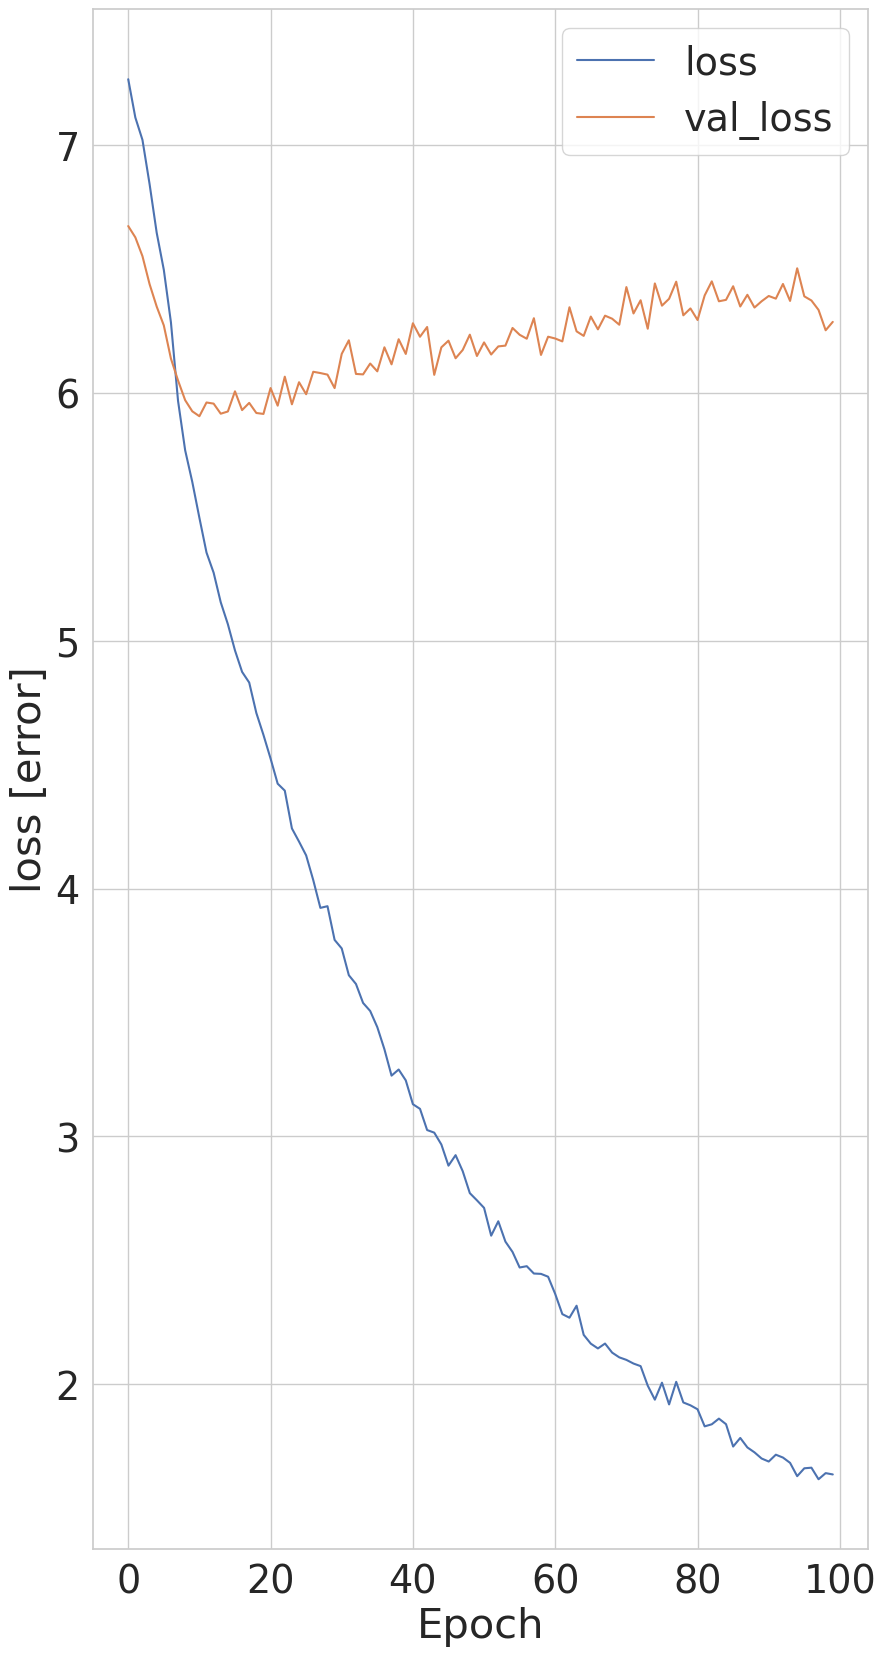

In [36]:
plot_loss(history)

In [ ]:
plot_mse(history)

In [40]:
test_results = {}
test_results["model"] = model.evaluate(test_features, test_labels, verbose=0)
print(test_results)

{'model': [6.3277692794799805, 79.70219421386719]}


In [39]:
train_predictions = model.predict(train_features).flatten()
r2 = r2_score(test_labels , train_predictions)

63/93 [===================>..........] - ETA: 0s

93/93 [==============================] - 0s 4ms/step


ValueError: Found input variables with inconsistent numbers of samples: [741, 2965]

24/24 [==============================] - 0s 3ms/step
Random forest validation r2 =  0.2364679335712253 rmse =  8.927609163594028


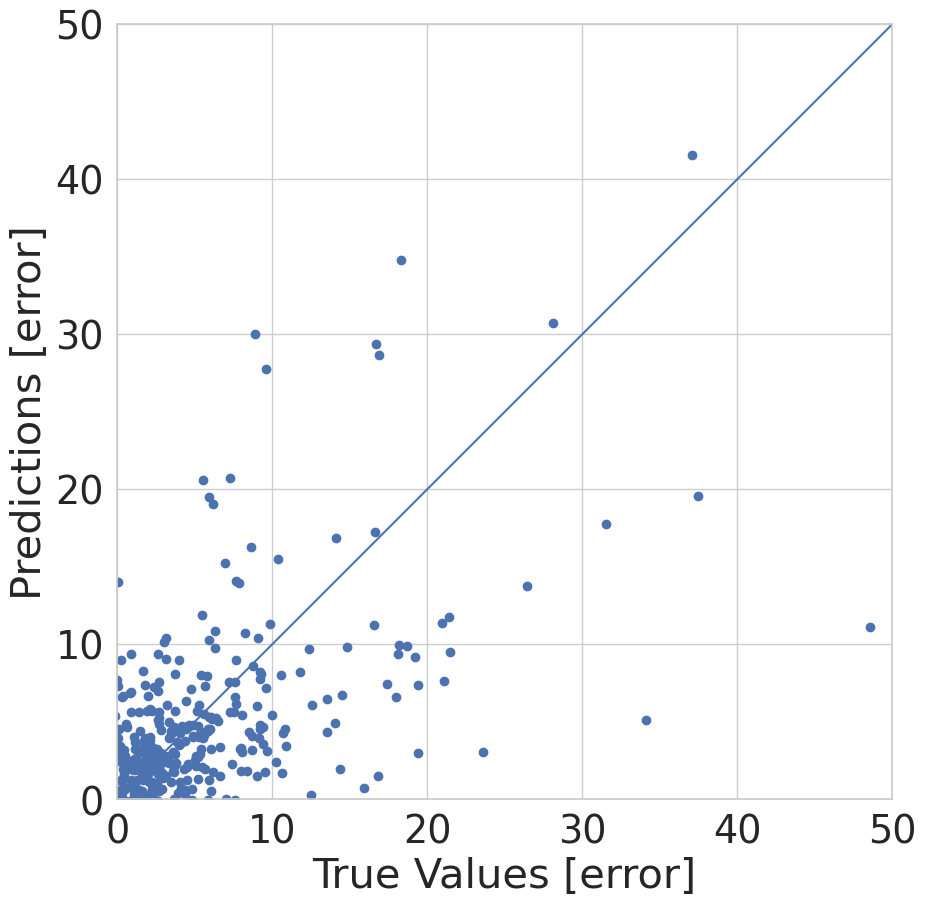

In [37]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [error]')
plt.ylabel('Predictions [error]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

r2 = r2_score(test_labels , test_predictions)
rmse = sqrt(mean_squared_error(test_labels , test_predictions))
print('Random forest validation r2 = ', r2, 'rmse = ', rmse)

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [error]')
_ = plt.ylabel('Count')

In [6]:
train_X, val_X, train_y, val_y = train_test_split(train_features, train_labels, test_size = 0.25, random_state = 14)

In [ ]:
RandomForest = RandomForestRegressor()
RandomForest.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_error = RandomForest.predict(val_X)
rmse = sqrt(mean_squared_error(val_y , predicted_error))
r2 = metrics.r2_score(val_y , predicted_error)
print('RandomForest rmse = ', rmse, 'r2 = ', r2)

In [ ]:
predicted_error = model.predict(test_features)
print(metrics.r2_score(test_labels, predicted_error))
print(sqrt(metrics.mean_squared_error(test_labels, predicted_error)))

In [ ]:
XGB = XGBRegressor()
XGB.fit(train_X,train_y, verbose=1)

# Get the mean absolute error on the validation data
predicted_error = XGB.predict(val_X)
mse = sqrt(mean_squared_error(val_y , predicted_error))
r2 = metrics.r2_score(val_y , predicted_error)
print('Random forest validation mse = ', mse, 'r2 = ', r2)

In [ ]:
predicted_y = model.predict(test_features)
print(metrics.r2_score(test_labels, predicted_y))
print(sqrt(metrics.mean_squared_error(test_labels, predicted_y)))

In [ ]:
model = GradientBoostingRegressor(random_state=0)
model.fit(train_X, train_y)

# Get the mean absolute error on the validation data
predicted_error = model.predict(val_X)
mse = sqrt(mean_squared_error(val_y , predicted_error))
r2 = metrics.r2_score(val_y , predicted_error)
print('Random forest validation mse = ', mse, 'r2 = ', r2)

In [ ]:
predicted_y = model.predict(test_features)
print(metrics.r2_score(test_labels, predicted_y))
print(sqrt(metrics.mean_squared_error(test_labels, predicted_y)))

In [7]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(train_X, train_y, verbose=False, plot=False)

# Get the mean absolute error on the validation data
predicted_error = model.predict(val_X)
mse = sqrt(mean_squared_error(val_y , predicted_error))
r2 = metrics.r2_score(val_y , predicted_error)
print('Random forest validation mse = ', mse, 'r2 = ', r2)

Random forest validation mse =  8.830329523154862 r2 =  0.5103173280842516


In [8]:
predicted_y = model.predict(test_features)
print(metrics.r2_score(test_labels, predicted_y))
print(sqrt(metrics.mean_squared_error(test_labels, predicted_y)))

0.366014524747148
8.13506791334419


In [9]:
result = test_labels.copy()
result = pd.DataFrame(result)
result['predicted_error'] = predicted_y.tolist()

In [10]:
a = dataset.drop(dataset.columns[3:103], axis=1, inplace=False)
a = a.drop(a.columns[2], axis=1, inplace=False)
a

,rmse,int_parsivel
2021-07-13 06:47:00+08:00,1.220273,6.269167
2021-07-20 07:57:00+08:00,2.247366,8.630833
2021-07-20 07:58:00+08:00,2.491312,10.952167
2021-07-20 07:59:00+08:00,2.070020,22.638167
2021-07-20 08:00:00+08:00,1.992452,22.559500
...,...,...
2022-10-30 14:21:00+08:00,2.073725,6.276167
2022-10-30 14:55:00+08:00,1.883256,7.326500
2022-10-30 15:13:00+08:00,1.775924,8.173333
2022-10-30 15:48:00+08:00,1.600264,18.630833


In [11]:
results = a.join(result)
#results.drop(results.columns[2:102], axis=1, inplace=True)
results.dropna(inplace=True)
results.head()

,rmse,int_parsivel,error,predicted_error
2021-07-13 06:47:00+08:00,1.220273,6.269167,-6.269167,-4.941199
2021-07-20 07:59:00+08:00,2.070020,22.638167,4.191833,5.070656
2021-07-20 16:43:00+08:00,0.920506,10.047833,-10.047833,0.183295
2021-07-21 08:31:00+08:00,1.177671,7.743000,5.727000,-0.052916
2021-07-21 10:54:00+08:00,1.786394,33.530000,3.970000,8.638269


In [12]:
results['pluvio'] =  results['int_parsivel'] + results['error']
results['cal_parsivel'] = results['int_parsivel'] + results['predicted_error']
results['cal_error'] = results['pluvio'] - results['cal_parsivel']
results.head()

,rmse,int_parsivel,error,predicted_error,pluvio,cal_parsivel,cal_error
2021-07-13 06:47:00+08:00,1.220273,6.269167,-6.269167,-4.941199,0.00,1.327967,-1.327967
2021-07-20 07:59:00+08:00,2.070020,22.638167,4.191833,5.070656,26.83,27.708822,-0.878822
2021-07-20 16:43:00+08:00,0.920506,10.047833,-10.047833,0.183295,0.00,10.231129,-10.231129
2021-07-21 08:31:00+08:00,1.177671,7.743000,5.727000,-0.052916,13.47,7.690084,5.779916
2021-07-21 10:54:00+08:00,1.786394,33.530000,3.970000,8.638269,37.50,42.168269,-4.668269


In [13]:
error = results.drop(results.columns[0:2], axis=1)
error = error.drop(error.columns[1:3], axis=1)
error = error.drop(error.columns[1], axis=1)
error.describe()

,error,cal_error
count,741.000000,741.000000
mean,-0.362795,-0.121347
std,10.223857,8.139657
min,-41.126833,-35.306137
25%,-6.403667,-4.270850
50%,0.899667,0.205782
75%,4.133500,3.731064
max,57.049833,50.331547


<Axes: >

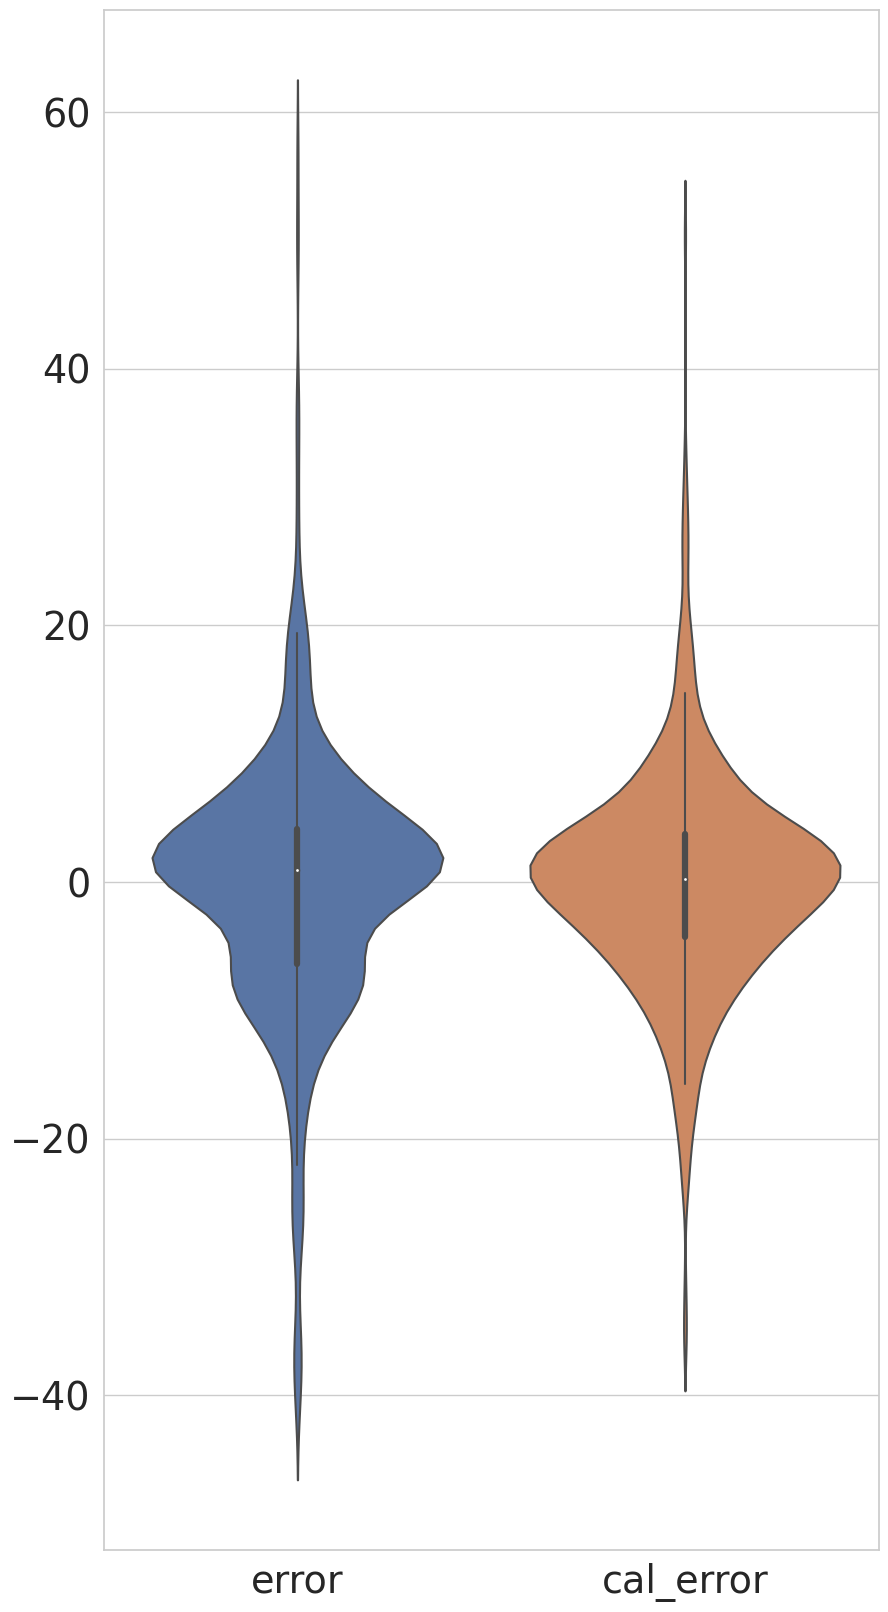

In [14]:
# violinplot
sns.set(rc={"figure.figsize": (10, 20)},font_scale=2.5)
sns.set_style("whitegrid")
sns.violinplot(data = error)

In [ ]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.set_style("whitegrid")
sns.violinplot(x=results["error"])

In [15]:
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], train_X.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, train_X)

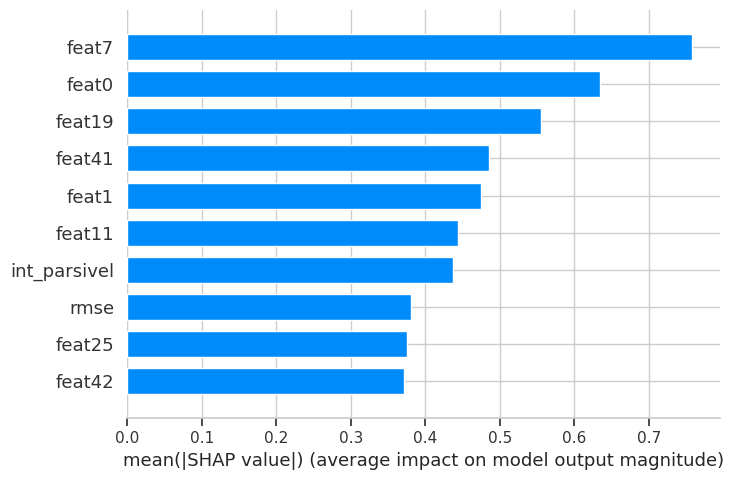

In [29]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_X, max_display=10, plot_type="bar")

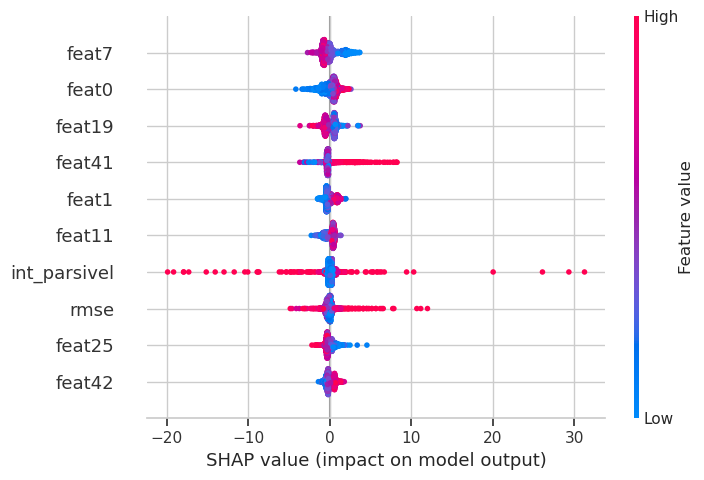

In [30]:
shap.summary_plot(shap_values, train_X, max_display=10)

In [26]:
shap.bar_plot(shap_values)
# Create a bar plot for the selected instance
shap.plots.bar(shap_values[0,:], max_display=10)  # Adjust max_display as needed
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
model = ltb.LGBMRegressor()
model.fit(train_X, train_y)

# Get the mean absolute error on the validation data
predicted_error = model.predict(val_X)
mse = sqrt(mean_squared_error(val_y , predicted_error))
r2 = metrics.r2_score(val_y , predicted_error)
print('Random forest validation mse = ', mse, 'r2 = ', r2)

In [ ]:
predicted_y = model.predict(test_features)
print(metrics.r2_score(test_labels, predicted_y))
print(sqrt(metrics.mean_squared_error(test_labels, predicted_y)))